In [1]:
import torch
torch.cuda.current_device()
from torch.nn import Module
from torch.nn import Linear
from torch import tanh, sigmoid, relu
from torch.nn.functional import mse_loss
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import diag_embed
from torch import prod
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.optim import Adam
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create model

In [3]:
x_size = 3
encoder_hidden_size= 500
z_size = 8
n_sample = 4
decoder_hidden_size = 500
x = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])

In [4]:
class encoder(Module):
    def __init__(self, input_size, hidden_size, output_dim, n_sample, device=None):
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.n_sample = n_sample
        self.device = device
        
        self.hidden_layer = Linear(input_size, hidden_size)
        self.output_mu = Linear(hidden_size, output_dim)
        self.output_sigma = Linear(hidden_size, output_dim)
    
    def forward(self, x):
        # input shape: batch * input_size
        # hidden shape: batch * hidden_size
        hidden = tanh(self.hidden_layer(x))
        # mu shape: batch * output_dim
        # sigma_sq shape: batch * output_dim
        mu = self.output_mu(hidden)
        sigma_sq = torch.exp(self.output_sigma(hidden))
        
        batch = x.shape[0]
        # epsilon shape: batch, n_sample, 1
        
        epsilon = torch.randn(batch, self.n_sample).unsqueeze(-1).to(self.device)
        # z shape: batch, n_sample, output_dim
        z = epsilon * sigma_sq.unsqueeze(1) + mu.unsqueeze(1)
        return (mu, sigma_sq, z)

In [5]:
# test encoder
Encoder = encoder(input_size=x_size, hidden_size=encoder_hidden_size,
                  output_dim=z_size,n_sample=n_sample, device=None)

encoder_mu,encoder_sigma_sq,z = Encoder(x)
print("encoder mu:",encoder_mu, "\n encoder sigma square:",encoder_sigma_sq, "\nz:",z)

encoder mu: tensor([[ 0.0918, -0.3216,  0.4660,  0.5007, -0.0387,  0.6666, -0.1789, -0.0018],
        [ 0.1855, -0.3590,  0.4948,  0.6441, -0.1202,  0.3469, -0.0291, -0.0060],
        [ 0.2259, -0.2979,  0.5512,  0.6563, -0.1476,  0.2083,  0.0179,  0.0156]],
       grad_fn=<AddmmBackward>) 
 encoder sigma square: tensor([[1.1135, 1.0421, 1.2204, 1.3713, 1.0406, 1.7766, 1.2111, 0.7519],
        [1.1835, 1.0559, 1.2616, 1.2415, 1.1581, 1.5653, 1.2023, 0.6206],
        [1.2661, 1.0081, 1.3206, 1.0623, 1.1624, 1.4839, 1.2272, 0.5998]],
       grad_fn=<ExpBackward>) 
z: tensor([[[-2.1484, -2.4181, -1.9893, -2.2581, -2.1322, -2.9077, -2.6154,
          -1.5146],
         [-0.6871, -1.0505, -0.3876, -0.4585, -0.7665, -0.5761, -1.0260,
          -0.5277],
         [ 1.3441,  0.8506,  1.8387,  2.0431,  1.1317,  2.6649,  1.1833,
           0.8440],
         [-0.7370, -1.0972, -0.4424, -0.5200, -0.8132, -0.6558, -1.0803,
          -0.5615]],

        [[ 0.1814, -0.3627,  0.4904,  0.6397, -0.1242,

In [6]:
class decoder(Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        
        self.hidden_layer = Linear(input_size, hidden_size)
        self.output_layer = Linear(hidden_size, output_dim)

    def forward(self, z):
        # z shape: batch, n_sample, input_size
        
        # hidden shape: batch, n_sample, hidden_size
        hidden = relu(self.hidden_layer(z))
        # output shape: batch, n_sample, output_size
        output = sigmoid(self.output_layer(hidden))
        
        return output

In [7]:
Decoder = decoder(input_size=z_size, 
                  hidden_size=decoder_hidden_size,
                  output_dim=x_size)
output = Decoder(z)

In [8]:
print("decoder output:", output, output.shape)

decoder output: tensor([[[0.3830, 0.4084, 0.4375],
         [0.4559, 0.4962, 0.4741],
         [0.5888, 0.4891, 0.4410],
         [0.4545, 0.4928, 0.4736]],

        [[0.4971, 0.5104, 0.4726],
         [0.5434, 0.5075, 0.4694],
         [0.5415, 0.5075, 0.4701],
         [0.5940, 0.4966, 0.4541]],

        [[0.4679, 0.5081, 0.4591],
         [0.4703, 0.5128, 0.4635],
         [0.5266, 0.5068, 0.4797],
         [0.5517, 0.5031, 0.4733]]], grad_fn=<SigmoidBackward>) torch.Size([3, 4, 3])


In [9]:
class VAE(Module):
    def __init__(self, x_size, encoder_hidden_size, decoder_hidden_size, z_size, n_sample, device=None):
        super(VAE, self).__init__()
        self.x_size = x_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.z_size = z_size
        self.n_sample = n_sample
        self.Encoder = encoder(input_size=x_size, hidden_size=encoder_hidden_size,
                  output_dim=z_size,n_sample=n_sample, device=device)
        self.Decoder = decoder(input_size=z_size, 
                  hidden_size=decoder_hidden_size,
                  output_dim=x_size)
    def forward(self, x):
        encoder_mu, encoder_sigma_sq, z = self.Encoder(x)
        output = self.Decoder(z)
        
        return (x, z, encoder_mu, encoder_sigma_sq, output)
    

# Load dataset

In [14]:
class preprocess_MNIST(Dataset):
    def __init__(self, train=True):
        super(preprocess_MNIST, self).__init__()
        self.train = train
        if self.train:
            self.underlying_tensor = MNIST(root="./", download=True).train_data
        else:
            self.underlying_tensor = MNIST(root="./", download=True).test_data
    def __getitem__(self, idx):
        return torch.flatten(self.underlying_tensor[idx].float()/255.0)
    def __len__(self):
        return self.underlying_tensor.shape[0]

In [15]:
dataset = preprocess_MNIST()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 10846790.23it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 132669.49it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 2767293.08it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 48325.73it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!



/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Loss function

In [16]:
class VAE_loss(torch.nn.modules.loss._Loss):
    def __init__(self, n_sample):
        super(VAE_loss, self).__init__()
        self.n_sample = n_sample
    def forward(self, x, encoder_mu, encoder_sigma_sq, output):
        original_dim = x.shape[1]
        # x shape: batch, encoder input_size
        # encoder_mu shape: batch, n_sample, encoder output dim
        # encoder_sigma_sq shape: batch, n_sample, encoder output dim
        # output shape: batch, n_sample, decoder output dim
        assert n_sample == output.shape[1]
        
        encoder_loss = torch.sum(1 + torch.log(encoder_sigma_sq) - \
            encoder_sigma_sq - torch.pow(encoder_mu, 2)) / 2 
        # decoder loss shape: batch, decoder output dim
        decoder_loss = mse_loss(x, torch.sum(output, dim=1)/ n_sample) * original_dim
        

        return -(encoder_loss - decoder_loss)

# Train

In [17]:
x_size = 784
encoder_hidden_size= 500
z_size = 10
n_sample = 1
decoder_hidden_size = 500

In [18]:
vae = VAE(x_size, encoder_hidden_size, decoder_hidden_size, z_size, n_sample, device=device).to(device)

In [19]:
optimizer = Adam(vae.parameters(), lr=0.0001)
vae_loss = VAE_loss(n_sample).to(device=device)

In [35]:
for epoch in range(50):
    loss_list = []
    for x in dataloader:
        vae.zero_grad()
        vae(x.to(device=device))
        z, log_prob, encoder_mu, encoder_sigma_sq, output = vae(x.to(device=device))
        loss = vae_loss(x.to(device=device), encoder_mu, encoder_sigma_sq, output)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
    print(sum(loss_list)/len(loss_list))

tensor(23.0606, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23.0316, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23.0066, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.9831, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.9533, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.9203, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8963, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8712, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8444, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8178, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.7887, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.7658, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.7383, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.7177, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.6885, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.6597, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.6338, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.6141, device='cuda:0'

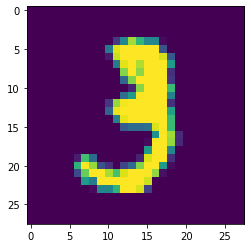

In [36]:
test_data = MNIST(root="./", download=False).test_data
sample = test_data[10].numpy()
plt.imshow(sample)

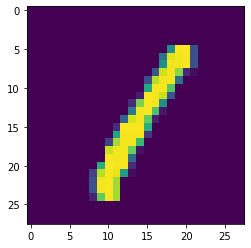

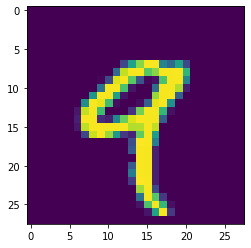

In [67]:
x = test_data[4].float().flatten()/255
plt.imshow(test_data[4])

In [68]:
encoder_mu, encoder_sigma_sq, z = vae.Encoder(x.unsqueeze(0).to(device))

#z, log_prob, encoder_mu, encoder_sigma_sq, decoder_mu, decoder_sigma_sq

In [69]:
decoder_output = vae.Decoder(z)

In [70]:
output = (decoder_output * 255).reshape(28, 28).detach().cpu().to(torch.uint8).numpy()

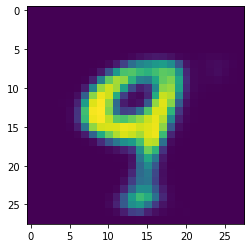

In [71]:
plt.imshow(output)